# Playground-series-s3e26

Kyle Lacson 


## I. Libraries and Packages

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os 
import warnings
warnings.filterwarnings('ignore')

### I.ii Import dataset

In [2]:
# --- Setting up the directory based on local repository or kaggle
if 'kylelacson' in os.getcwd():
    base_dir = os.getcwd()
else:
    base_dir = r'/kaggle/input/playground-series-s3e26' 
    
for i in os.listdir(base_dir):
    if 'playground-series-s3e26' in i:
        base_dir = os.path.join(base_dir,i)   
    
# --- Importing csv files from directory
for i in os.listdir(base_dir):
    if 'sample' in i:
        sample = pd.read_csv(os.path.join(base_dir,i))
    elif 'train' in i:
        train = pd.read_csv(os.path.join(base_dir,i))
    elif 'test' in i:
        test = pd.read_csv(os.path.join(base_dir,i))
    else:
        continue

In [3]:
train.nunique().sort_values()[:10]

Drug              2
Sex               2
Ascites           2
Hepatomegaly      2
Spiders           2
Status            3
Edema             3
Stage             4
Prothrombin      49
Bilirubin       111
dtype: int64

### I.iii Transfrom dataset

In [4]:
# --- Setting aside category/object columns to transform
category = train.select_dtypes(include = object)
number = train.select_dtypes(include = np.number)

In [5]:
from sklearn.preprocessing import LabelEncoder
'''
Function: Label encode categorical columns.
'''
def label_encoder(df: pd.DataFrame):
    for i in df.columns:
        le = LabelEncoder()
        le.fit(df[i])
        df[i] = le.transform(df[i])
    return df

In [6]:
# --- Initializing label_encoder function
category = label_encoder(category)

In [7]:
# --- Merging the new initialized dataset
data = pd.concat([number,category],axis = 1).drop(columns = 'id')

In [8]:
data.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Status
0,999,21532,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,0,1,0,0,0,0,2
1,2574,19237,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,1,0,0,0,0,0,0
2,3428,13727,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,1,0,0,1,1,2,2
3,2576,18460,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,1,0,0,0,0,0,0
4,788,16658,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,1,0,0,1,0,0,0


## II. Explore data 

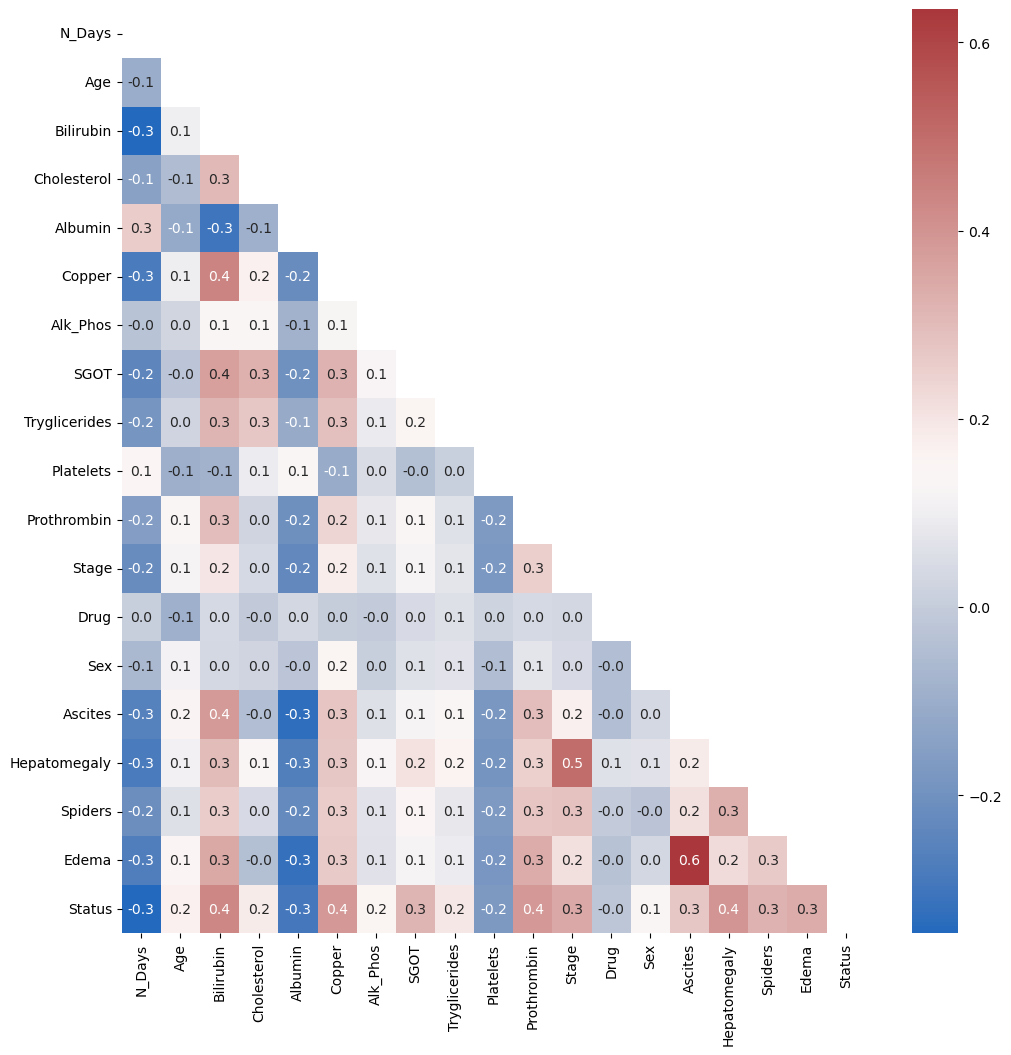

In [9]:
# --- Heatmap
plt.figure(figsize = (12,12))
mask = np.triu(np.ones_like(data.corr()))
sns.heatmap(data = data.corr(), annot = True, fmt = '.1f', cmap = 'vlag', mask = mask);

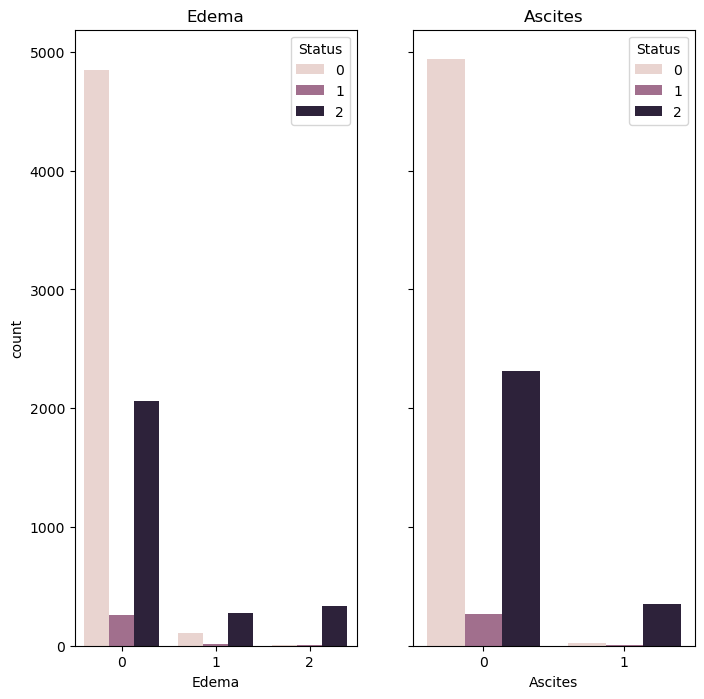

In [10]:
#  Ascites & Edema
fig, ax = plt.subplots(1,2,figsize = (8,8), sharey = True)
sns.countplot(data = data, x = 'Edema', hue = 'Status', ax = ax[0])
sns.countplot(data = data, x = 'Ascites', hue = 'Status', ax = ax[1])
ax[0].set_title('Edema')
ax[1].set_title('Ascites');


### II.ii  Prepare dataset

In [12]:
# --- Split dataset
from sklearn.model_selection import train_test_split
X = data.drop(columns = 'Status')
y = data.Status

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, shuffle = True)

# --- Creating a valdiation set 
train_split = int(len(X_train) * 0.10) # 10 percent of the split training set will be used for the evalution set 
X_val, y_val = X_train[(len(X_train) - train_split):], y_train[(len(y_train) - train_split):]
X_train, y_train = X_train[:(len(X_train) - train_split)], y_train[:(len(y_train) - train_split)]

In [26]:
# --- Scaling dataset (not truly needed for tree based classifiers)
from sklearn.preprocessing import StandardScaler

def scale_dataframes(dataframe: pd.DataFrame):
    scaler = StandardScaler()
    df = pd.DataFrame(data = scaler.fit_transform(dataframe), columns = dataframe.columns)
    return df

In [27]:
X_train_sc = scale_dataframes(X_train)
X_test.sc = scale_dataframes(X_val)
X_test_sc =  scale_dataframes(X_test)

## III. Classification Modeling

### III.ii Decision Tree Classifier (SKLEARN)

In [ ]:
# --- Sklearn Decision Tree Classifier 
from sklearn.tree import DecisionTreeClassifier

dt_sk = DecisionTreeClassifier(random_state = 42)
dt_sk.fit(X_train_sc, y_train)
y_dt_pred = dt_sk.predict(X_test_sc)

### III.iii Random Forest Classifier (SKLEARN)

In [28]:
# --- Sklearn Random Forest Tree Classifier
from sklearn.ensemble import RandomForestClassifier

rf_sk = RandomForestClassifier(random_state = 42)
rf_sk.fit(X_train_sc, y_train)
y_rf_pred = rf_sk.predict(X_test_sc)

### III.iv Random Forest XGBoost Classifier (Gradient Boosting) 

In [71]:
# --- Check if a GPU is available and set device to built in GPU support (MPS)
import torch
device = torch.device('mps') if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
device

device(type='mps')

In [73]:
# --- XGBoost Classifier and Random Forest Classifier
from xgboost import XGBClassifier, XGBRFClassifier

# Gradient Boosting
params = {
    'random_state': 42,
    'n_jobs': 2,
    'verbose': 2,
    'device': device
    # eval_metric:
}
xgb_clf = XGBClassifier(**params)
xgb_clf.fit(X_train_sc, y_train)
y_xgbclf_pred = xgb_clf.predict(X_test_sc)

# Random Forest
xgbrf_clf = XGBRFClassifier(**params)
xgbrf_clf.fit(X_train_sc, y_train)
y_xgbrf_pred = xgbrf_clf.predict(X_test_sc)

[00:09:34] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "device", "verbose" } are not used.

[00:09:35] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "device", "verbose" } are not used.



### III.v. Classifier Catboost

In [ ]:
# --- Catboost Classifier


## IV. Metrics

In [ ]:
# --- Metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

def metrics_func(y_pred, classifier):
    acc = accuracy_score(y_test,y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    # --- Confusion Matrix
    cm = confusion_matrix(y_test,y_pred, labels = classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels = classifier.classes_)
    disp.plot()
    plt.show()

    print(classification_report(y_test, y_pred))
    print('*'*75,'\n')
    print(f'Accuracy: {acc}\nBalanced Accuracy: {bal_acc}')
    
#     return acc, bal_acc


In [ ]:
# XGBRFBoosting (Random Forest)
print('XGBRF Classifier')
metrics_func(y_xgbrf_pred, xgbrf_clf)

In [ ]:
# XGBoosting (Gradient Boosting)
print('XGBoost Classifier')
metrics_func(y_xgbclf_pred, xgb_clf)

In [ ]:
# Random Forest (SK)
print('Random Forest')
metrics_func(y_rf_pred,rf_sk)

In [ ]:
# Decision Tree (SK)
print('Decision Tree')
metrics_func(y_dt_pred, dt_sk)

**Notes:** Need to handle class imbalance. Big disparity in class labeling.